In [1]:
import time
# Imports Gunnerus model
from mclsimpy.simulator import CSAD_DP_6DOF

# Imports waves
from mclsimpy.waves import JONSWAP, WaveLoad

# Imports utilities
import numpy as np
import matplotlib.pyplot as plt



In [2]:

start = time.time()

dt = 0.01
simtime = 100
t = np.arange(0, simtime, dt)

vessel = CSAD_DP_6DOF(dt=dt, method='RK4')
print(f"Init boat took {time.time() - start:.2f} seconds")

eta = np.zeros((6, len(t)))
nu = np.zeros((6, len(t)))
wave_load = np.zeros((6, len(t)))

Init boat took 0.06 seconds


In [3]:
Uc = 0.0
beta_c = 0

start = time.time()
hs = 5.0/90 # Significant wave height
tp = 9.0*np.sqrt(1/90) # Peak period
gamma = 3.3 # Peak factor

wp = 2*np.pi/tp # Peak frequency
wmin = 0.5*wp
wmax = 3.0*wp

N = 100 # Number of wave components

wave_freqs = np.linspace(wmin, wmax, N)

jonswap = JONSWAP(wave_freqs)

omega, wave_spectrum = jonswap(hs=hs, tp=tp, gamma=gamma)

dw = (wmax - wmin) / N
wave_amps = np.sqrt(2 * wave_spectrum * dw)
rand_phase = np.random.uniform(0, 2*np.pi, size=N)
wave_angles = np.ones(N) * np.pi / 4

waveload = WaveLoad(
    wave_amps=wave_amps,
    freqs=wave_freqs,
    eps=rand_phase,
    angles=wave_angles,
    config_file=vessel._config_file,
    interpolate=True,
    qtf_method="Newman",      # Use Newman to approximate the QTF matrices.
    deep_water=True,            # Assume deep water conditions.
)

print(f"Init the everything related to the waves took {time.time() - start:.2f} seconds")


[[ 0.          0.32222377 -1.78734188 ...  1.32448864 -1.85506228
  -1.63942266]
 [-0.32222377  0.         -2.10956565 ...  1.00226487 -2.17728604
  -1.96164642]
 [ 1.78734188  2.10956565  0.         ...  3.11183052 -0.06772039
   0.14791923]
 ...
 [-1.32448864 -1.00226487 -3.11183052 ...  0.         -3.17955091
  -2.96391129]
 [ 1.85506228  2.17728604  0.06772039 ...  3.17955091  0.
   0.21563962]
 [ 1.63942266  1.96164642 -0.14791923 ...  2.96391129 -0.21563962
   0.        ]]
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
Init the everything related to the waves took 0.29 seconds


In [4]:
eta_init = np.zeros(6)
nu_init = np.zeros(6)


vessel.set_eta(eta_init)
vessel.set_nu(nu_init)

print("Starting simulation")
start = time.time()
tau_control = np.array([0, 0, 0, 0, 0, 0], dtype=float)
for i in range(len(t)):
    tau_wave = waveload(t[i], vessel.get_eta())
    tau = tau_control + tau_wave
    eta[:, i] = vessel.get_eta()
    nu[:, i] = vessel.get_nu()
    wave_load[:, i] = tau_wave
    vessel.integrate(Uc, beta_c, tau)


print(f"Simulation took {time.time() - start:.2f} seconds")
print(f"Simtime/Real: {simtime / (time.time() - start):.2f}")

Starting simulation
Simulation took 48.76 seconds
Simtime/Real: 2.05


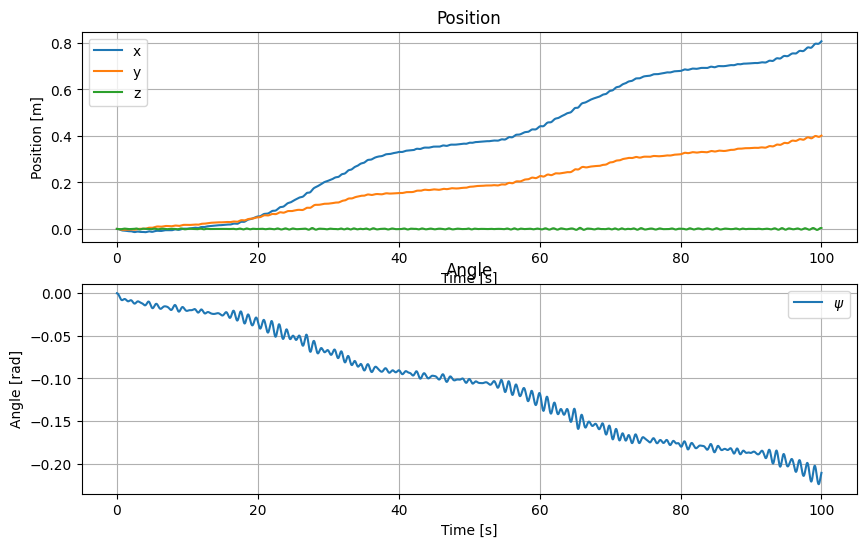

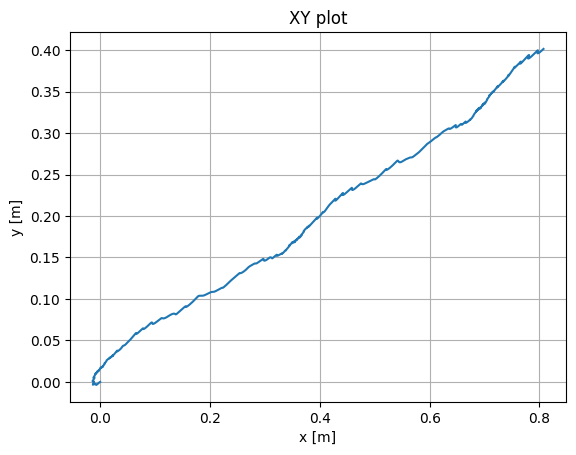

In [5]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].plot(t, eta[0, :], label='x')
axes[0].plot(t, eta[1, :], label='y')
axes[0].plot(t, eta[2, :], label='z')
axes[0].legend()
axes[0].grid()
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Position [m]')
axes[0].set_title('Position')

axes[1].plot(t, eta[5, :], label=r"$\psi$")
axes[1].legend()
axes[1].grid()
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [rad]')
axes[1].set_title('Angle')

plt.show()


# Plot XY plot to position
plt.figure()
plt.plot(eta[0, :], eta[1, :])
plt.grid()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('XY plot')
plt.show()



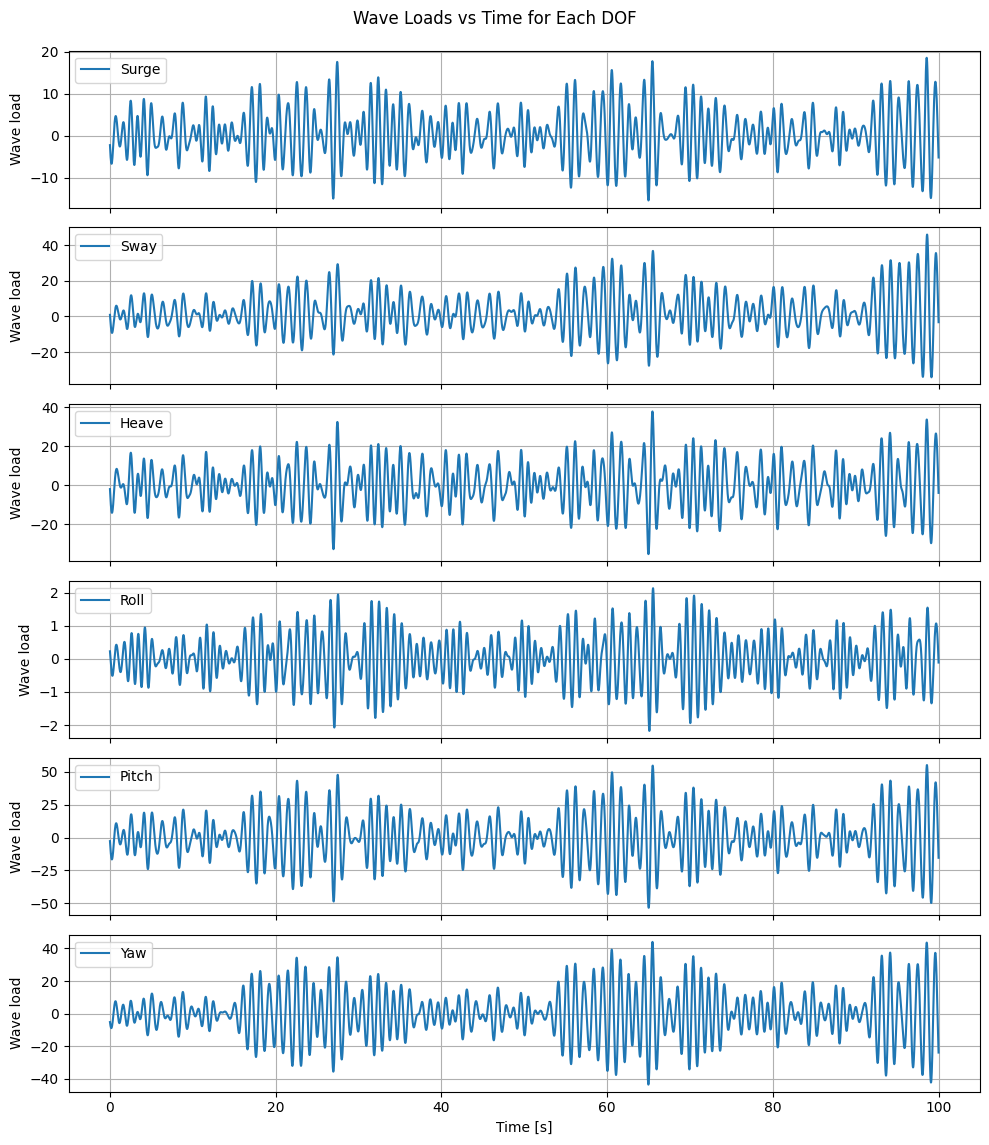

In [6]:
# ----------------------------------------------------------------------------
# Plot the wave loads vs time for each degree of freedom (DOF)
# ----------------------------------------------------------------------------

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 12), sharex=True)
dof_labels = ['Surge', 'Sway', 'Heave', 'Roll', 'Pitch', 'Yaw']

for i in range(6):
    axes[i].plot(t, wave_load[i, :], label=f'{dof_labels[i]}')
    axes[i].set_ylabel('Wave load')
    axes[i].legend()
    axes[i].grid()

axes[-1].set_xlabel('Time [s]')
fig.suptitle('Wave Loads vs Time for Each DOF', y=0.95)  # Adjusted y position
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()